In [36]:
# データセットのラベル名
cols = ["file_name", "class_id", "species", "breed_id"]

In [37]:
import glob
list_path = ("./esrgan/input/annotations/list.txt")

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

labels = []
with open(list_path, 'r') as f:
    lines = f.read().splitlines()
    for line in lines:
        if line.startswith('#'):
            continue
        labels.append(line.split(' '))
f.close()

labels_df = pd.DataFrame(labels, columns=cols)
labels_df = labels_df[['file_name', 'species']]

In [39]:
cat_label_df = labels_df[labels_df["species"]=='1']
cat_label_df = cat_label_df.reset_index(drop=True)

In [40]:
seed = 1990124
random_crop_times = 4
# クロップする画像のサイズ
crop_size = (128, 128) # (height, width)
dataset_name = 'cat_face'

In [70]:
import logging

def random_crop(image, crop_size):
    """画像を指定されたサイズになるようにランダムに切り出す
    Args:
        image (np.array): ランダムに切り出す画像
        crop_size (tuple): ランダムに切り出すサイズ
    Returns:
        np.array: 'ランダムに切り出された画像'
    """
    h, w, _ = image.shape
    if (w - crop_size[1]) < 0:
        print(f'left: {w - crop_size[1]}, top: {h - crop_size[0]}, crop_size:{crop_size}')


    top = np.random.randint(0, h - crop_size[0])
    left = np.random.randint(0, w - crop_size[1])

    bottom = top + crop_size[0]
    right = left + crop_size[1]

    image = image[top:bottom, left:right, :]
    return image

In [71]:
train_df, test_df = train_test_split(cat_label_df, test_size=5, random_state=seed)
train_df, demo_df = train_test_split(train_df, test_size=1, random_state=seed)

In [74]:
import os
import cv2
from tqdm import tqdm

image_dir = './esrgan/input/images/'
train_dir = "./esrgan/input/cat_face/train"

# 学習に用いる画像
for item in tqdm(train_df.file_name, total=len(train_df)):
    image_name = f'{item}.jpg'
    image_path = os.path.join(image_dir, image_name)
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    if (h < crop_size[0] | (w < crop_size[1])):
        # image_name = f'{image_name} size is invalid h: {h}, w: {w}'
        print(f'{image_name} siz is invalid. h: {h}, w: {w}')
        continue

    for num in range(random_crop_times):
        h, w, _ = image.shape
        if ((h - crop_size[0]) | (w - crop_size[1])):
            break
        cropped_image = random_crop(image, crop_size=crop_size)
        image_save_name = f'{item}_{num:03}.jpg'
        cropped_image_save_path = os.path.join(train_dir, image_save_name)
        os.makedirs(os.path.dirname(cropped_image_save_path), exist_ok=True)
        cv2.imwrite(cropped_image_save_path, cropped_image)
        

  6%|▌         | 132/2365 [00:00<00:05, 408.07it/s]

Bombay_171.jpg siz is invalid. h: 108, w: 144


 27%|██▋       | 629/2365 [00:01<00:04, 432.38it/s]

Abyssinian_63.jpg siz is invalid. h: 116, w: 150


 87%|████████▋ | 2059/2365 [00:04<00:00, 437.26it/s]

Egyptian_Mau_122.jpg siz is invalid. h: 112, w: 150


 93%|█████████▎| 2198/2365 [00:05<00:00, 431.73it/s]

Bombay_70.jpg siz is invalid. h: 103, w: 137


100%|██████████| 2365/2365 [00:05<00:00, 429.01it/s]

Egyptian_Mau_44.jpg siz is invalid. h: 125, w: 250


In [75]:
# 学習の深度確認の画像
import shutil

test_dir = "./esrgan/input/cat_face/test"
for item in test_df.file_name:
    image_name = f"{item}.jpg"
    image_path = os.path.join(image_dir, image_name)

    image_save_path = os.path.join(test_dir, image_name)
    os.makedirs(os.path.dirname(image_save_path), exist_ok=True)
    shutil.copy(image_path, image_save_path)

In [76]:
# 学習後に超解像をためす画像p124
demo_dir  = "./esrgan/input/cat_face/demo"
for item in demo_df.file_name:
    image_name = f'{item}.jpg'
    image_path = os.path.join(image_dir, image_name)

    image_save_path = os.path.join(demo_dir, image_name)
    os.makedirs(os.path.dirname(image_save_path), exist_ok=True)
    shutil.copy(image_path, image_save_path)

画像に用いる画像


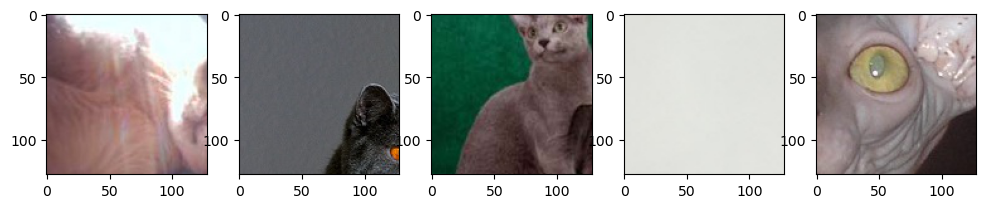

学習の進度確認の画像


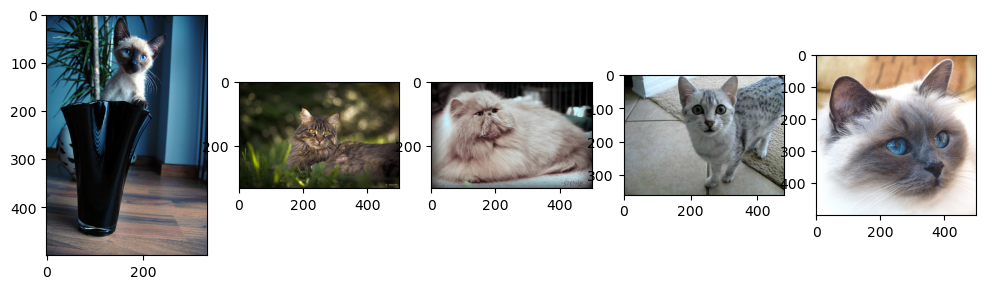

学習後に超解像


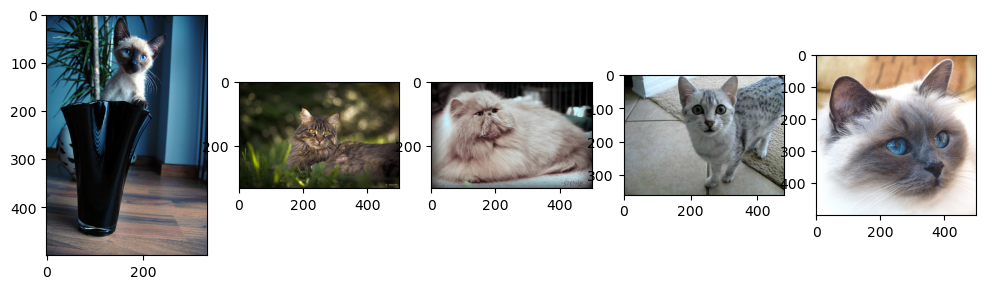

In [77]:
# p125
import matplotlib.pyplot as plt
import glob

print('画像に用いる画像')
plt.figure(figsize=(12, 6))
train_paths = glob.glob(os.path.join(train_dir, '*'))
for num, path in enumerate(train_paths[0:5], 1):
    image = cv2.imread(path)
    plt.subplot(1, 5, num)
    plt.imshow(image[:, :, ::-1])
plt.show()

print('学習の進度確認の画像')
plt.figure(figsize=(12, 4))
test_paths = glob.glob(os.path.join(test_dir, '*'))
for num, path in enumerate(test_paths, 1):
    image = cv2.imread(path)
    plt.subplot(1, 5, num)
    plt.imshow(image[:,:,::-1])
plt.show()

print('学習後に超解像')
plt.figure(figsize=(12, 4))
demo_path = glob.glob(os.path.join(demo_dir, '*'))
for num, path in enumerate(test_paths, 1):
    image = cv2.imread(path)
    plt.subplot(1, 5, num)
    plt.imshow(image[:,:,::-1])
plt.show()

In [80]:
import torch
class ImageDataset(Dataset):
    """
    学習のためのDatasetクラス
    32*32の低解像度の本物画像と、
    128*128の本物画像を出力する
    """
    def __init__(self, dataset_dir, hr_shape) -> None:
        hr_height, hr_width = hr_shape
        
        self.lr_transform = torch.transforms.Compose([
            torch.transforms.Resize((hr_height // 4, hr_height // 4),
                                    Image.BICUBIC),
            torch.transforms.ToTensor(),
            torch.transforms.Normalize(mean, std)])
        
        self.hr_transform = torch.transoforms.Compose([
            torch.transforms.Resize((hr_height, hr_height),
                                    Image.BICUBIC),
            torch.transforms.ToTensor(),
            torch.transforms.Normalize(mean, std)])
        
        self.files = sorted(glob.glob(os.path.join(dataset_dir, '*')))

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.filex)])
        
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)
        
        return {'lr': img_lr, 'hr': img_hr}
    
    def __len__(self):
        return len(self.files)
    

AttributeError: module 'torch' has no attribute 'Dataset'

In [81]:
class TestImageDataset(Dataset):
    """
    Generatorによる途中経過の確認のためのDatasetクラス
    入力画像から高さと幅それぞれ1/4の低解像度の本物画像と
    入力画像を本物画像として出力する
    """
    def __init__(self) -> None:
        self.hr_transform = torch.transforms.Compos([
            torch.transforms.ToTensor(),
            torch.transforms.Normalize(mean, std)])
        self.files = sorted(glob.glob(os.path.join(dataset_dir, '*')))

    def lr_transform(self, img, img_size):
        img_width, img_height = img_size

        self__lr_transform = torch.transforms.Compose([
            torch.transforms.Resize((img_height // 4,
                                     img_width // 4),
                                     Image.BICUBIC),
            torch.transforms.ToTensor(),
            torch.Normalize(mean, std)])
        img = self.__lr_transforms(img)
        return img
    
    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img_size = img.size
        img_lr = self.lr_transform(img, img_size)
        img_hr = self.hr_transform(img)
        return {'lr': img_lr, 'hr': img_hr}
    
    def __len__(self):
        return len(self.files)


AttributeError: module 'torch' has no attribute 'Dataset'

In [83]:
class DenseResidualBlock(torch.nn.Module):
    """
    GeneratorのDenseResidualBlockのクラス
    """
    def __init__(self, filters, res_scale=0.2) -> None:
        super().__init__()
        super(DenseResidualBlock, self).__init__()
        self.res_scale = res_scale

        def block(in_features, non_linearity=True):
            layers = [torch.nn.Conv2d(in_features,
                                      filters, 3, 1, 1, bias=True)]
            if non_linearity:
                layers += [torch.nn.LeakyReLU()]
            return torch.nn.Sequential(*layers)
        
        self.b1 = block(in_features=1 * filters)
        self.b2 = block(in_features=2 * filters)
        self.b3 = block(in_features=3 * filters)
        self.b4 = block(in_features=4 * filters)
        self.b5 = block(in_features=5 * filters,
                        non_linearity=False)
        self.blocks = [self.b1, self.b2, self.b3, self.b4, self.b5]

    def forward(self, x):
        inputs = x
        for block in self.blocks:
            out = block(inputs)
            inputs = torch.cat([inputs, out], 1)

        return out.mul(self.res_scale) + x
                


In [84]:
class ResidualInResidualDenseBlock(torch.nn.Module):
    def __init__(self, filters, res_scale=0.1) -> None:
        super(ResidualInResidualDenseBlock, self).__init__()
        self.res_scale = res_scale
        self.dense_blocks = torch.nn.Sequential(
            DenseResidualBlock(filters),
            DenseResidualBlock(filters),
            DenseResidualBlock(filters),
        )
    
    def forward(self, x):
        return self.dense_blocks(x).mul(self.res_scale) + x

In [85]:
class GeneratorRRDB(torch.nn.Module):
    """
    Generatorのクラス
    """
    def __init__(self, channels, filters=64, num_res_blocks=16, num_upsample=2) -> None:
        super(GeneratorRRDB, self).__init__()

        self.conv1 = torch.nn.Conv2d(channels,
                                     filters,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)

        self.res_blocks = torch.nn.Sequential(*[
            DenseResidualBlock(filters)
            for _ in range(num_res_blocks)])
        self.conv2 = torch.nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1)

        upsample_layers = []

        for _ in range(num_upsample):
            upsample_layers += [
                torch.nn.Conv2d(filters, filters * 4, kernel_size = 3, stride=1, padding=1),
                torch.nn.LeakyReLU(),
                torch.PixelShuffle(upscale_factor=2)
            ]
        
        self.upsampling = torch.nn.Sequential(*upsample_layers)
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(filters, filters, kernel_size=3,
                            stride=1, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(filters, channels, kernel_size=3, stride=1, padding=1),
        )

        def forward(self, x):
            out1 = self.conv1(x)
            out = self.res_blocks(out1)
            out2 = self.conv2d(out)
            out = torch.add(out1, out2)
            out = self.upsampling(out)
            out = self.conv3(out)
            return out

In [87]:
import torchvision
class FeatureExtractor(torch.nn.Module):
    """
    Perceputual loss を計算するために特徴りょうを抽出するためのクラス
    """
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = torchvision.models.vgg19(pretrained=True)
        self.vgg19_54 = torch.nn.Sequential(*list(
            vgg19_model.features.children())[:35])
        
    def forward(self, img):
        return self.vgg19_54(img)

In [89]:
class Discriminator(torch.nn.Module):
    def __init__(self, input_shape) -> None:
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels = in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def descriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(torch.nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))

            if not first_block:
                layers.append(torch.nn.BatchNorm2d(out_filters))
            layers.append(torch.nn.LeakyLeRU(0.2, inplace=True))
            layers.append(torch.nn.Conv2d(out_filters,
                                        out_filters,
                                        kernel_size=3,
                                        stride=2,
                                        padding=1))
            layers.append(torch.nn.BatchNorm2d(out_filters))
            layers.append(torch.nn.LeakyLeRU(0.2, inplace=True))
            return layers
    
        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            print(descriminator_block(in_filters,
                                    out_filters,
                                    first_block=(i==0)))
            layers.extend(descriminator_block(in_filters,
                                            out_filters,
                                            first_block=(i==0)))
            in_filters = out_filters

        layers.append(torch.nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = torch.nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)
    


In [92]:
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
import sys
from torchvision.utils import save_image

log_dir = "./esrgan/logs"

class ESRGAN():
    """
    ESRGANの処理を実装するクラス
    """
    def __init__(self, opt) -> None:
        # 生成器
        self.generator = GeneratorRRDB(
            opt.channels, filters = 64,
            num_res_blocks=opt.residual_blocks).to(opt.device)
        # 生成器
        self.discriminator = Discriminator(
            input_shape = (opt.channels, *hr_shape)).to(opt.device)
        
        # 特徴量抽出器
        self.feature_extractor = FeatureExtractor().to(opt.device)
        self.feature_extractor.eval()
        self.criterion_GAN = torch.nn.BCEWithLongitsLoss().to(opt.device)
        self.criterion_content = torch.nn.L1Loss().to(opt.device)
        self.criterion_pixel = torch.nn.L1Loss().to(opt.device)

        self.optimizer_G = torch.optim.Adam(self.generator.parameters(),
                                            lr=opt.lr, betas=(opt.b1, opt.b2))
        self.optimizer_D = torch.optim.Adam(self.descriminator.parameters(),
                                            lr=opt.lr, beta=(opt.b1, opt.b2))
        
        self.Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
        self.writer = SummaryWriter(log_dir=log_dir)

    def pre_train(self, imgs, batches_done):
        """
        Pixel loss 飲みで事前学習を行う
        """
        imgs_lr = Variable(imgs['lr'].type(self.Tensor))
        imgs_hr = Variable(imgs['hr'].type(self.Tensor))

        valid = Variable(
            self.Tensor(np.ones((imgs_lr.size(0),
                                    *self.discriminator.output_shape))),
                                    requires_grad=False)
        fake = Variable(
            self.Tensor(np.zeros((imgs_lr.size(0), *self.discriminator.output_shape))),
            requires_grad=False)
        
        self.optimizer_G.zero_grad()

        # 低解像度の本物画像を入力にして生成画像を出力
        gen_hr = self.generator(imgs_lr)
        
        # Pixel loss
        loss_pixel = self.criterion_pixel(gen_hr, imgs_hr)

        loss_pixel.backward()
        self.optimizer_G.step()
        train_info = {'epoch': epoch,
                        'batch_num': batch_num,
                        'loss_pixel': loss_pixel.item()}
        
        sys.stdout.write('\r{}'.format('\t'*10))
        sys.stdout.write('\r{}'.format(train_info))
        self.save_loss(train_info, batches_done)

    def train(self, imgs, batches_done):
        """
        Pixel loss 以外の損失も含めて本学習を行う
        """

        imgs_lr = Variable(imgs['lr'].type(self.Tensor))
        imgs_hr = Variable(imgs['hr'].type(self.Tensor))

        valid = Variable(
            self.Tensor(np.zeros((imgs_lr.size(0),
                                    *self.discriminator.output_shape))),
                                requires_grad=True)
        fake = Variable(
            self.Tensor(np.zeros((imgs_lr.size(0),
                                    *self.discriminator.output_shape))),
                                requires_grad=False)
        
        self.optimizer_G.zero_grad()

        # 低解像度の本物画像を入力にして生成画像を出力
        gen_hr = self.generator(imgs_lr)

        # Pixel loss
        loss_pixel = self.criterion_pixel(gen_hr, imgs_hr)
        pred_real = self.discriminator(imgs_hr).detach()
        pred_fake = self.discriminator(gen_hr)

        # Adversarial loss
        loss_GAN = self.criterion_GAN(
            pred_fake - pred_real.mean(0, keepdim=True), valid)
        
        # Perceptual loss
        gen_feature = self.feature_extractor(gen_hr)
        real_feature = self.feature_extractor(imgs_hr).detach()
        loss_content = self.criterion_content(gen_feature, real_feature)

        # Generator loss
        loss_G = loss_content + opt.lambda_adv * loss_GAN + opt.lambda_pixel * loss_pixel

        loss_G.backward()
        self.optimizer_G.step()
        self.optimizer_D.zero_grad()

        pred_real = self.discriminator(imgs_hr)
        pred_fake = self.discriminator(gen_hr.detach())

        # Adversarial loss
        loss_real = self.criterion_GAN(
            pred_real - pred_fake.mean(0, keepdim=True), valid)
        loss_fake = self.criterion_GAN(
            pred_fake - pred_real.mean(0, keepdim=True), fake)
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        self.optimizer_D.step()

        train_info = {'epoch': epoch, 'batch_num': batch_num,
                        'loss_D': loss_D.item(), 'loss_G': loss_G.item(),
                        'loss_content': loss_content.item(),
                        'loss_GAN': loss_GAN.item(),
                        'loss_pixel': loss_pixel.item()}
        if batch_num == 1:
            sys.stdout.write(f'\n{train_info}')
        else:
            sys.stdout.write('\r{}'.format('\t'*20))
            sys.stdout.write('\r{}'.format(train_info))
        sys.stdout.flush()

    def save_loss(self, train_info, batches_done):
        """
        lossの保存
        """
        for k, v in train_info.items():
            self.writer.add_scatter(k, v, batches_done)

    def save_image(self, imgs, batches_done):
        with torch.no_grad():
            gen_hr = self.generator(imgs_lr)
            gen_hr = denormalize(gen_hr)
            self.writer.add_image(f'image_{i}', gen_hr[0], batches_done)

            # TODO format()の書き方を確認するp139
            image_batch_save_dir = os.path.join(image_test_save_dir, '{:03}'.format(i))

            os.makedirs(image_batch_save_dir, exits_ok=True)
            # TODO format()の書き方を確認するp139
            save_image(gen_hr,
                       os.path.join(image_batch_save_dir,
                        '{:09}.png'.format(batches_done)),
                        nrow=1,
                        normalize=False)

    def save_weight(self, batches_done):
        """
        重みの保存
        """

        generator_weight_path = os.path.join(weight_save_dir,
                                             "discriminator_{:08}.path".format(batches_done))

        torch.save(self.generator.satate_dict(), generator_weight_path)
        torch.save(self.discriminator.state_dict(), discriminator_weight_path)


ModuleNotFoundError: No module named 'tensorboard'

In [93]:
# p141
n_epoch = 50
batch_size = 16
warmup_batches = 500
sample_interval = 100
checkpoint_interval = 1000
n_cpu = 8
hr_height = 128
hr_width = 128
channels = 3
residual_blocks = 23
lr = 0.0002
b1 = 0.9
b2 = 0.999
lambda_adv = 5.00E-03
lambda_pixel = 1.00E-02

In [94]:
esrgan =ESRGAN(opt)
for epoch in range(1, opt.n_epoch + 1):
    for batch_num, imgs in enumerate(train_dataloader):
        batches_done = (epoch - 1) * len(train_dataloader) + batch_num
        
        # 事前学習
        if batches_done <= opt.warmup_batches:
            esrgan.pre_train(imgs, batches_done)
        # 本学習
        else:
            esrgan.train(imgs, batches_done)
        
        # 高解像どの生成画像の保存
        if batches_done % opt.sample_interval == 0:
            for i, imgs in enumerate(test_dataloader):
                esrgan.save_image(imgs, batches_done)
        
        # 学習した重みの保存
        if batches_done % opt.chekckopoint_interval == 0:
            esrgan.save_weight(batches_done)


NameError: name 'ESRGAN' is not defined

In [95]:
# p143
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

with torch.no_grad():
    for i, imgs in enumerate(demo_dataloader):
        imgs_lr = Variable(imgs['lr'].type(Tensor))

        gen_hr = generator(imgs_lr)
        imgs_lr = torch.nn.functional.interpolate(imgs_lr, scale_factor=4)
        imgs_lr = denomalize(imgs_lr)
        gen_hr = denormalize(gen_hr)
        os.makedirs(demo_out_dir, exist_ok=True)

        save_image(imgs_lr, os.path.join(demo_out_dir, "low_{:01}.png".format(i)),
                   nrow = 1, normalize=False)
        save_image(gen_hr, os.path.join(demo_out_dir, "gen_hr_{:01}.png".format(i)),
                   nrow=1, normalize=False)

    

NameError: name 'demo_dataloader' is not defined

In [96]:
#p144
demo_out_dir = "./esrgan/output/"
demo_data_dir = './esrgan/input/cat_face/demo/'

lr_img_paths = glob.glob(os.path.join(demo_out_dir, 'low*'))
hr_img_paths = glob.glob(os.path.join(demo_data_dir, '*'))
gen_hr_img_paths = glob.glob(os.path.join(dmeo_out_dir, 'gen_hr*'))

lr_img_paths.sort()
hr_img_paths.sort()
gen_hr_img_paths.sort()

plt.figure(figsize=(25, 20))
for lr_img_path, hr_img_path, gen_hr_img_path in zip(lr_img_paths, hr_img_paths, gen_hr_img_paths):
    image_name = os.path.basename(hr_img_path)
    lr_image = cv2.imread(lr_img_path)
    hr_image = cv2.imread(hr_img_path)

    gen_hr_image = cv2.imread(gen_hr_img_path)

    plt.subplot(1, 3, 1)
    plt.imshow(lr_imgage[:, :, ::-1])
    plt.title('{}_{}'.format(image_name, 'lr_image'))

    plt.subplot(1,3,2)
    plt.imshow(hr_image[:,:,::-1])
    plt.title('{}_{}'.format(image_name, 'hr_image'))

    plt.subplot(1,3,3)
    plt.imshow(gen_hr_image[:,:,::-1])
    plt.title('{}_{}'.format(image_name, 'gen_hr_image'))

    plt.show()

NameError: name 'dmeo_out_dir' is not defined